<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing\_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


***


## Import Libraries and Define Auxiliary Functions


We will import the following libraries for the lab


In [1]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
# Metrics for classification models
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
# Random forest
from sklearn.ensemble import RandomForestClassifier
# Confusion Matrix plot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# Pickle allows us to save our models
import pickle
#XGBoost
from xgboost import XGBClassifier
from xgboost import plot_importance

import warnings
warnings.filterwarnings("ignore")


This function is used to create a table with metrics for models like random forest and XGBoost

In [2]:
def make_results(model_name:str, model_object, metric:str):
  '''
  Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy
  
  Returns a pandas df with the F1, recall, precision, and accuracy scores
  for the model with the best mean 'metric' score across all validation folds.  
  '''

  # Create dictionary that maps input metric to actual metric name in GridSearchCV
  metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

  # Get all the results from the CV and put them in a df
  cv_results = pd.DataFrame(model_object.cv_results_)

  # Isolate the row of the df with the max(metric) score
  best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

  # Extract Accuracy, precision, recall, and f1 score from that row
  f1 = best_estimator_results.mean_test_f1
  recall = best_estimator_results.mean_test_recall
  precision = best_estimator_results.mean_test_precision
  accuracy = best_estimator_results.mean_test_accuracy
  
  # Create table of results
  table = pd.DataFrame()
  table = table.append({'Model': model_name,
                        'Precision': precision,
                        'Recall': recall,
                        'F1': f1,
                        'Accuracy': accuracy,
                        },
                        ignore_index=True
                       )
  
  return table

This function is used to create a table with test scores

In [3]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out: 
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = round(accuracy_score(y_test_data, preds), 3)
    precision = round(precision_score(y_test_data, preds), 3)
    recall = round(recall_score(y_test_data, preds), 3)
    f1 = round(f1_score(y_test_data, preds), 3)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision], 
                        'recall': [recall],
                        'f1': [f1],
                        'accuracy': [accuracy]
                        })
  
    return table

These functions are used to save and read the models

In [4]:
def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [5]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

## Load the dataframe


Load the data


In [6]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")

# If you were unable to complete the previous lab correctly you can uncomment and load this csv

# data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_2.csv')

data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [7]:
X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')

# If you were unable to complete the previous lab correctly you can uncomment and load this csv

#X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_3.csv')

X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [8]:
X.shape

(90, 83)

## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [9]:
Y = data['Class'].to_numpy()

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [10]:
# students get this 
transform = preprocessing.StandardScaler()

In [11]:
X = transform.fit_transform(X)

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

we can see that we only have 18 test samples.


In [13]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [14]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10, refit='precision')
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             refit='precision')

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [15]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


In [16]:
train_pred = logreg_cv.predict(X_train)

In [17]:
print('F1_score(train): {num:.4f}'.format(num = f1_score(Y_train, train_pred)))
print('Precision(train): {num:.4f}'.format(num = precision_score(Y_train, train_pred)))
print('Accuracy(train): {num:.4f}'.format(num = accuracy_score(Y_train, train_pred)))
print('Recall(train): {num:.4f}'.format(num = recall_score(Y_train, train_pred)))

F1_score(train): 0.9143
Precision(train): 0.8421
Accuracy(train): 0.8750
Recall(train): 1.0000


In [18]:
test_pred = logreg_cv.predict(X_test)

In [19]:
print('F1_score(test): {num:.4f}'.format(num = f1_score(Y_test, test_pred)))
print('Precision(test): {num:.4f}'.format(num = precision_score(Y_test, test_pred)))
print('Accuracy(test): {num:.4f}'.format(num = accuracy_score(Y_test, test_pred)))
print('Recall(test): {num:.4f}'.format(num = recall_score(Y_test, test_pred)))

F1_score(test): 0.8889
Precision(test): 0.8000
Accuracy(test): 0.8333
Recall(test): 1.0000


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [20]:
logreg_cv.score(X_test, Y_test)

0.8333333333333334

Lets look at the confusion matrix:


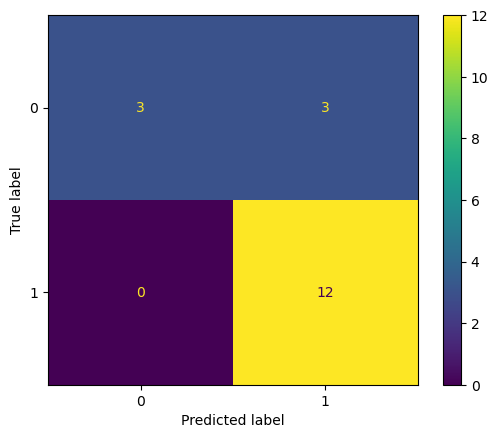

In [21]:
cm = confusion_matrix(Y_test, test_pred, labels=logreg_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=logreg_cv.classes_)
disp.plot();

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [22]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [23]:
svm_cv = GridSearchCV(svm, parameters, cv=10, refit='precision')
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')},
             refit='precision')

In [24]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


In [25]:
train_pred = svm_cv.predict(X_train)
print('F1_score(train): {num:.4f}'.format(num = f1_score(Y_train, train_pred)))
print('Precision(train): {num:.4f}'.format(num = precision_score(Y_train, train_pred)))
print('Accuracy(train): {num:.4f}'.format(num = accuracy_score(Y_train, train_pred)))
print('Recall(train): {num:.4f}'.format(num = recall_score(Y_train, train_pred)))

F1_score(train): 0.9231
Precision(train): 0.8571
Accuracy(train): 0.8889
Recall(train): 1.0000


In [26]:
test_pred = svm_cv.predict(X_test)
print('F1_score(test): {num:.4f}'.format(num = f1_score(Y_test, test_pred)))
print('Precision(test): {num:.4f}'.format(num = precision_score(Y_test, test_pred)))
print('Accuracy(test): {num:.4f}'.format(num = accuracy_score(Y_test, test_pred)))
print('Recall(test): {num:.4f}'.format(num = recall_score(Y_test, test_pred)))

F1_score(test): 0.8889
Precision(test): 0.8000
Accuracy(test): 0.8333
Recall(test): 1.0000


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [27]:
svm_cv.score(X_test, Y_test)

0.8333333333333334

We can plot the confusion matrix


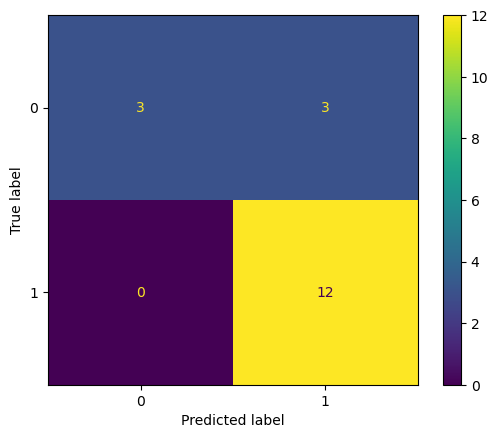

In [28]:
cm = confusion_matrix(Y_test, test_pred, labels=svm_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=svm_cv.classes_)
disp.plot();

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [29]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [30]:
tree_cv = GridSearchCV(tree, parameters, cv=10, refit='precision')
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             refit='precision')

In [31]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
accuracy : 0.8767857142857143


In [32]:
train_pred = tree_cv.predict(X_train)
print('F1_score(train): {num:.4f}'.format(num = f1_score(Y_train, train_pred)))
print('Precision(train): {num:.4f}'.format(num = precision_score(Y_train, train_pred)))
print('Accuracy(train): {num:.4f}'.format(num = accuracy_score(Y_train, train_pred)))
print('Recall(train): {num:.4f}'.format(num = recall_score(Y_train, train_pred)))

F1_score(train): 0.9320
Precision(train): 0.8727
Accuracy(train): 0.9028
Recall(train): 1.0000


In [33]:
test_pred = tree_cv.predict(X_test)
print('F1_score(test): {num:.4f}'.format(num = f1_score(Y_test, test_pred)))
print('Precision(test): {num:.4f}'.format(num = precision_score(Y_test, test_pred)))
print('Accuracy(test): {num:.4f}'.format(num = accuracy_score(Y_test, test_pred)))
print('Recall(test): {num:.4f}'.format(num = recall_score(Y_test, test_pred)))

F1_score(test): 0.8571
Precision(test): 0.7500
Accuracy(test): 0.7778
Recall(test): 1.0000


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [34]:
tree_cv.score(X_test, Y_test)

0.7777777777777778

We can plot the confusion matrix


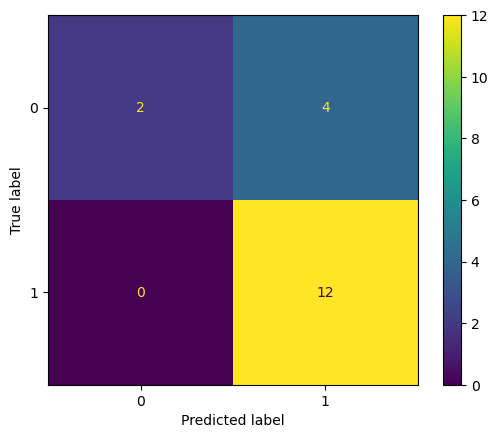

In [35]:
cm = confusion_matrix(Y_test, test_pred, labels=tree_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=tree_cv.classes_)
disp.plot();

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [36]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [37]:
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [38]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


In [39]:
train_pred = knn_cv.predict(X_train)
print('F1_score(train): {num:.4f}'.format(num = f1_score(Y_train, train_pred)))
print('Precision(train): {num:.4f}'.format(num = precision_score(Y_train, train_pred)))
print('Accuracy(train): {num:.4f}'.format(num = accuracy_score(Y_train, train_pred)))
print('Recall(train): {num:.4f}'.format(num = recall_score(Y_train, train_pred)))

F1_score(train): 0.9038
Precision(train): 0.8393
Accuracy(train): 0.8611
Recall(train): 0.9792


In [40]:
test_pred = knn_cv.predict(X_test)
print('F1_score(test): {num:.4f}'.format(num = f1_score(Y_test, test_pred)))
print('Precision(test): {num:.4f}'.format(num = precision_score(Y_test, test_pred)))
print('Accuracy(test): {num:.4f}'.format(num = accuracy_score(Y_test, test_pred)))
print('Recall(test): {num:.4f}'.format(num = recall_score(Y_test, test_pred)))

F1_score(test): 0.8889
Precision(test): 0.8000
Accuracy(test): 0.8333
Recall(test): 1.0000


## TASK  11


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [41]:
tree_cv.score(X_test, Y_test)

0.7777777777777778

We can plot the confusion matrix


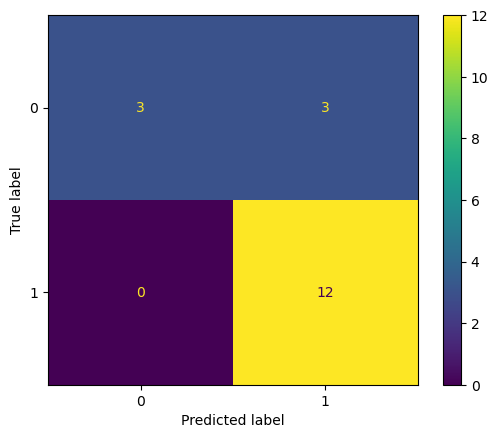

In [42]:
cm = confusion_matrix(Y_test, test_pred, labels=knn_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=knn_cv.classes_)
disp.plot();

Additionally I decided to apply some advanced ML modeles like XGBoost and Random Forest

In [43]:
rf = RandomForestClassifier(random_state=0)
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0, 'sqrt', 'log2'],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [150],
             }
scoring = {'accuracy', 'precision', 'recall', 'f1'}
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1', n_jobs=-1)

In [44]:
rf_cv.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [3, 5, None],
                         'max_features': [1.0, 'sqrt', 'log2'],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [150]},
             refit='f1', scoring={'accuracy', 'f1', 'recall', 'precision'})

In [45]:
print("tuned hpyerparameters :(best parameters) ", rf_cv.best_params_)
print("accuracy :",rf_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 3, 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
accuracy : 0.9045386192754613


In [46]:
results = make_results('random forest: f1', rf_cv, 'f1')
results

,Model,Precision,Recall,F1,Accuracy
0,random forest: f1,0.840606,0.98,0.904539,0.861905


In [47]:
preds = rf_cv.best_estimator_.predict(X_test)

In [48]:
rf_cv_test_scores = get_test_scores('random forest: f1', preds, Y_test)
rf_cv_test_scores

,model,precision,recall,f1,accuracy
0,random forest: f1,0.8,1.0,0.889,0.833


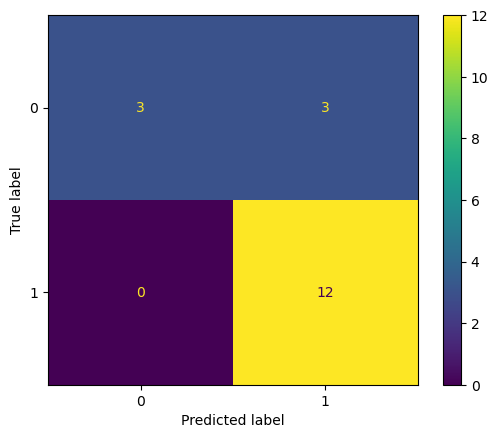

In [49]:
cm = confusion_matrix(Y_test, preds, labels=rf_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf_cv.classes_)
disp.plot();

In [50]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic')  

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,6,8,10,12], 
             'min_child_weight': [2,3,5,7],
             'learning_rate': [0.01, 0.1, 0.15],
             'n_estimators': [300, 700]
             }   

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1', n_jobs=-1)

In [51]:
xgb_cv1.fit(X_train, Y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.15],
                         'max_depth': [4, 6, 8, 10, 12],
                         'min_child_weight': [2, 3, 5, 7],
                         'n_estimators': [300, 700]},
             refit='f1', scoring={'accuracy', 'f1', 'recall', 'precision'})

In [52]:
xgb_cv1.best_score_

0.8373626373626373

In [53]:
xgb_cv1.best_params_

{'learning_rate': 0.15,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 700}

In [54]:
results = make_results('XGBoost: f1', xgb_cv1, 'f1')
results

,Model,Precision,Recall,F1,Accuracy
0,XGBoost: f1,0.835165,0.854167,0.837363,0.777778


In [55]:
preds = xgb_cv1.best_estimator_.predict(X_test)

In [56]:
xgb_cv_test_scores = get_test_scores('XGBoost 1: f1', preds, Y_test)
xgb_cv_test_scores

,model,precision,recall,f1,accuracy
0,XGBoost 1: f1,0.917,0.917,0.917,0.889


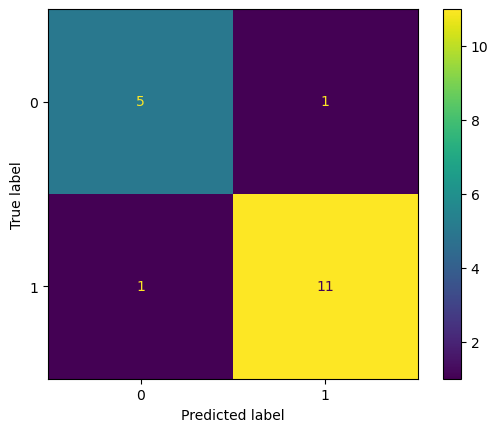

In [57]:
# Generate array of values for confusion matrix
cm = confusion_matrix(Y_test, preds, labels=xgb_cv1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=xgb_cv1.classes_)
disp.plot();

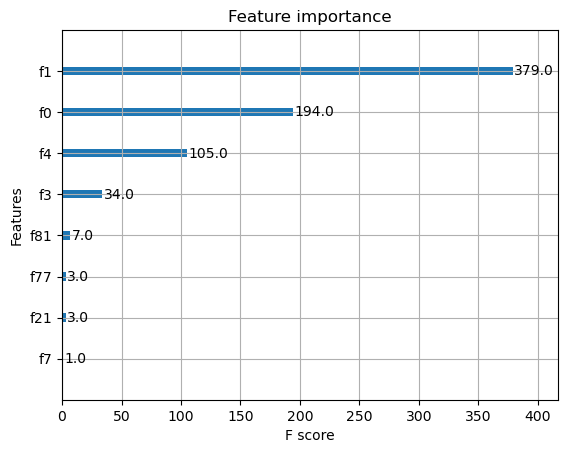

In [58]:
plot_importance(xgb_cv1.best_estimator_, max_num_features=10);

Plot above show that the most importan features for the model are:

- `PayloadMass`


- `FlightNumber`


- `ReusedCount`

## TASK  12


Find the method performs best:


After I added some advanced models, XGBoost model showed the best results on the test sample. The metrics of the model on the test sample are as follows:

- Precision: 0.917
- Recall: 0.917
- F1: 0.917	
- Accuracy: 0.889

All of the metrics except Recall are higher than in other models. In my opinion Recall is not the best metric, because it measures proportion of True positive predictions among False negative and True positive predictions. I think that the most appropriate metric here is Precision that measures proportion of True positive predictions among all positive predictions, because in this project we are trying to predict reuse of the first stage. So, the model will be more useful if we could predict a more accurate proportion of positive outcomes with lower amount of False positive predictions.

## Authors


<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By    | Change Description      |
| ----------------- | ------- | ------------- | ----------------------- |
| 2021-08-31        | 1.1     | Lakshmi Holla | Modified markdown       |
| 2020-09-20        | 1.0     | Joseph        | Modified Multiple Areas |


Copyright © 2020 IBM Corporation. All rights reserved.
